<a href="https://colab.research.google.com/github/GabrielaMorera/Modelo_Clusters_SECOP/blob/main/SECOP_MODELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El documento ofrece un análisis crítico de las visualizaciones y datos resultantes del proceso de modelado topical aplicado a contratos de la región de Boyacá. Se examina la distribución documental, las palabras clave identificadas y la comparación metodológica entre algoritmos de agrupamiento, con el objetivo de evaluar la efectividad del proceso de reducción dimensional y la coherencia semántica de los tópicos resultantes.

In [3]:
!pip install bertopic
!pip install umap-learn
!pip install sentence-transformers
!pip install wordcloud
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# 1. Descargar y cargar los datos
print("Descargando datos de SECOP II...")
# URL de la API de Datos Abiertos Colombia para SECOP II
url = "https://www.datos.gov.co/resource/p6dx-8zbt.csv"
# Limitamos la descarga a 2`000.000 registros para manejar el tamaño
query_params = "?$limit=2000000"
df = pd.read_csv(url + query_params)
print(f"Datos descargados: {df.shape[0]} registros")

Descargando datos de SECOP II...
Datos descargados: 2000000 registros


In [6]:
# 2. Filtrar para Boyacá
print("Filtrando datos para Boyacá...")
# Columnas de interés para el filtrado
cols_to_check = ['departamento_entidad', 'ciudad_entidad', 'departamento_proveedor', 'ciudad_proveedor']
# Crear una máscara para filtrar por Boyacá en cualquiera de estas columnas
boyaca_mask = df[cols_to_check].apply(lambda x: x.str.contains('Boyac[aá]', case=False, na=False, regex=True)).any(axis=1)
df_boyaca = df[boyaca_mask].copy()
print(f"Datos filtrados para Boyacá: {df_boyaca.shape[0]} registros")

Filtrando datos para Boyacá...
Datos filtrados para Boyacá: 56750 registros


In [7]:
# 3. Definir palabras vacías a eliminar (lista completa de palabras sin significado contextual)
# Estas son palabras que no aportan significado semántico en el contexto de los contratos
palabras_vacias = {
    # Artículos definidos e indefinidos
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'lo', 'del', 'al',

    # Pronombres
    'que', 'quien', 'quienes', 'cual', 'cuales', 'donde', 'cuando', 'como',
    'esto', 'esta', 'este', 'estos', 'estas', 'eso', 'esa', 'ese', 'esos', 'esas',
    'yo', 'tu', 'él', 'ella', 'nosotros', 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas',
    'mí', 'ti', 'sí', 'conmigo', 'contigo', 'consigo',
    'me', 'te', 'se', 'nos', 'os', 'le', 'les', 'lo', 'la', 'los', 'las',

    # Preposiciones
    'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'en', 'entre',
    'hacia', 'hasta', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras',
    'durante', 'mediante', 'excepto', 'salvo', 'incluso', 'más', 'menos',

    # Conjunciones
    'y', 'e', 'ni', 'o', 'u', 'bien', 'sea', 'ya', 'pero', 'mas', 'aunque', 'sino',
    'siquiera', 'mientras', 'porque', 'pues', 'si', 'cuando', 'como',

    # Adverbios comunes
    'no', 'sí', 'aquí', 'allí', 'ahí', 'allá', 'acá', 'ahora', 'entonces', 'después',
    'antes', 'aún', 'todavía', 'ya', 'siempre', 'nunca', 'jamás', 'casi', 'apenas',
    'tan', 'tanto', 'muy', 'bastante', 'demasiado', 'más', 'menos', 'poco', 'mucho',

    # Palabras comunes en contratos que no aportan al contexto específico
    'través', 'manera', 'forma', 'modo', 'vez', 'veces', 'parte', 'partes',
    'fin', 'fines', 'caso', 'casos', 'hecho', 'hechos',

    # Verbos auxiliares y comunes
    'es', 'son', 'era', 'eran', 'será', 'serán', 'sido', 'ser', 'estar', 'estaba',
    'estaban', 'está', 'están', 'estará', 'estarán', 'estado', 'ha', 'han', 'había',
    'habían', 'habrá', 'habrán', 'haber', 'tengo', 'tienes', 'tiene', 'tenemos',
    'tenéis', 'tienen', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron',
    'tendré', 'tendrás', 'tendrá', 'tendremos', 'tendréis', 'tendrán', 'tener',
    'hago', 'haces', 'hace', 'hacemos', 'hacéis', 'hacen', 'hice', 'hiciste',
    'hizo', 'hicimos', 'hicisteis', 'hicieron', 'haré', 'harás', 'hará',
    'haremos', 'haréis', 'harán', 'hacer',

    # Números escritos
    'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez',
    'cien', 'mil', 'millón', 'millones', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto'
}

# Versiones con tilde
palabras_con_tilde = {
    'él', 'mí', 'tú', 'sí', 'más', 'según', 'través', 'después', 'además', 'aún',
    'cómo', 'dónde', 'cuándo', 'quién', 'cuál', 'están', 'está', 'estará', 'será',
    'tendré', 'tendrá', 'harás', 'hará', 'haré', 'estén', 'esté'
}

# Combinar todas las palabras vacías
palabras_vacias.update(palabras_con_tilde)

# Obtener stopwords de NLTK en español y combinarlas con nuestras palabras vacías
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))
todas_palabras_vacias = spanish_stopwords.union(palabras_vacias)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# 4. Preprocesamiento de texto
print("Preprocesando descripciones de contratos...")
# Asegurarse de que la columna de descripción existe
description_col = 'detalle_del_objeto_a_contratar'
if description_col not in df_boyaca.columns:
    description_col = 'objeto_a_contratar'
    if description_col not in df_boyaca.columns:
        # Intentar encontrar alguna columna con descripción
        possible_cols = [col for col in df_boyaca.columns if 'objeto' in col.lower() or 'descri' in col.lower()]
        if possible_cols:
            description_col = possible_cols[0]
        else:
            raise ValueError("No se encontró columna con descripciones de contratos")

# Función para limpiar texto y eliminar palabras vacías
def limpiar_texto(texto):
    if pd.isna(texto):
        return ""

    # Convertir a minúsculas
    texto = str(texto).lower()

    # Eliminar caracteres especiales pero mantener acentos y ñ
    texto = re.sub(r'[^\w\sáéíóúüñ]', ' ', texto)

    # Eliminar dígitos
    texto = re.sub(r'\d+', ' ', texto)

    # Dividir en palabras
    palabras = texto.split()

    # Eliminar palabras vacías
    palabras_filtradas = [palabra for palabra in palabras if palabra not in todas_palabras_vacias and len(palabra) > 2]

    # Unir palabras filtradas
    texto_filtrado = ' '.join(palabras_filtradas)

    # Eliminar espacios múltiples
    texto_filtrado = re.sub(r'\s+', ' ', texto_filtrado).strip()

    return texto_filtrado

# Aplicar limpieza y filtrado a las descripciones
df_boyaca['clean_description'] = df_boyaca[description_col].apply(limpiar_texto)

# Eliminar filas con descripciones vacías o muy cortas después del filtrado
df_boyaca = df_boyaca[df_boyaca['clean_description'].str.len() > 10].reset_index(drop=True)
print(f"Registros con descripciones válidas después del filtrado: {df_boyaca.shape[0]}")

Preprocesando descripciones de contratos...
Registros con descripciones válidas después del filtrado: 55848


In [9]:
# 5. Vectorización con Sentence Transformers
print("Vectorizando descripciones con Sentence Transformers...")
# Cargar modelo de Sentence Transformers (multilingüe para español)
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
# Convertir descripciones ya filtradas a embeddings
descriptions = df_boyaca['clean_description'].tolist()
embeddings = model.encode(descriptions, show_progress_bar=True)

Vectorizando descripciones con Sentence Transformers...


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/1746 [00:00<?, ?it/s]

In [10]:
# 6. Agrupación con KMeans (entre 30-50 grupos)
print("Agrupando contratos con KMeans...")
# Determinar número óptimo de clusters (entre 30 y 50)
n_clusters = min(max(30, int(df_boyaca.shape[0] / 100)), 50)
print(f"Número de clusters seleccionado: {n_clusters}")

# Aplicar KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_boyaca['cluster'] = kmeans.fit_predict(embeddings)

Agrupando contratos con KMeans...
Número de clusters seleccionado: 50


In [11]:
# 7. Analizar los clusters
print("Analizando clusters resultantes...")
# Obtener las palabras más frecuentes en cada cluster
cluster_summary = {}
for cluster_id in range(n_clusters):
    cluster_texts = df_boyaca[df_boyaca['cluster'] == cluster_id]['clean_description']
    text = ' '.join(cluster_texts)
    words = text.split()

    # Contar palabras
    word_counts = {}
    for word in words:
        if len(word) > 2:  # Filtro adicional para palabras muy cortas
            word_counts[word] = word_counts.get(word, 0) + 1

    # Obtener las 15 palabras más frecuentes
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    top_words = [word for word, count in top_words]

    # Guardar en el diccionario de resumen
    cluster_summary[cluster_id] = {
        'count': len(cluster_texts),
        'top_words': top_words,
        'sample_contracts': df_boyaca[df_boyaca['cluster'] == cluster_id][description_col].head(3).tolist() # Mostrar texto original
    }

Analizando clusters resultantes...


In [12]:
#8. Creando la modelación de tópicos con BERTopic

# Configuración básica de UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Vectorizador con stopwords personalizadas
vectorizer = CountVectorizer(
    stop_words=list(todas_palabras_vacias),
    min_df=5,  # Aparece en al menos 5 documentos
    max_df=0.8  # Aparece en máximo 80% de documentos
)

# Modelo de clustering (HDBSCAN es el que BERTopic usa por defecto)
hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Inicializar BERTopic con todos los componentes explícitos
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    language="spanish",
    nr_topics="auto",
    verbose=True
)

# Ajustar el modelo con los embeddings ya calculados
print("Entrenando modelo BERTopic...")
topics, probs = topic_model.fit_transform(descriptions, embeddings)

# Guardar tópicos en el dataframe
df_boyaca['bertopic'] = topics

# Ver información de los tópicos generados
print(f"Número de tópicos encontrados: {len(topic_model.get_topics())}")
# Configuración básica de UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Vectorizador con stopwords personalizadas
vectorizer = CountVectorizer(
    stop_words=list(todas_palabras_vacias),
    min_df=5,  # Aparece en al menos 5 documentos
    max_df=0.8  # Aparece en máximo 80% de documentos
)

# Modelo de clustering (HDBSCAN es el que BERTopic usa por defecto)
hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Inicializar BERTopic con todos los componentes explícitos
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    language="spanish",
    nr_topics="auto",
    verbose=True
)

# Ajustar el modelo con los embeddings ya calculados
print("Entrenando modelo BERTopic...")
topics, probs = topic_model.fit_transform(descriptions, embeddings)

# Guardar tópicos en el dataframe
df_boyaca['bertopic'] = topics

# Ver información de los tópicos generados
print(f"Número de tópicos encontrados: {len(topic_model.get_topics())}")
print(f"Distribución de documentos por tópico: {np.bincount(np.array([t if t >= 0 else 0 for t in topics]))}")

2025-03-22 14:50:20,459 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Entrenando modelo BERTopic...


2025-03-22 14:52:48,232 - BERTopic - Dimensionality - Completed ✓
2025-03-22 14:52:48,235 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-22 14:52:58,241 - BERTopic - Cluster - Completed ✓
2025-03-22 14:52:58,246 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-03-22 14:53:00,187 - BERTopic - Representation - Completed ✓
2025-03-22 14:53:00,188 - BERTopic - Topic reduction - Reducing number of topics
2025-03-22 14:53:04,316 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-22 14:53:05,872 - BERTopic - Representation - Completed ✓
2025-03-22 14:53:05,882 - BERTopic - Topic reduction - Reduced number of topics from 1335 to 919
2025-03-22 14:53:08,485 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Número de tópicos encontrados: 919
Entrenando modelo BERTopic...


2025-03-22 14:55:21,403 - BERTopic - Dimensionality - Completed ✓
2025-03-22 14:55:21,407 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-22 14:55:28,338 - BERTopic - Cluster - Completed ✓
2025-03-22 14:55:28,339 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-03-22 14:55:30,557 - BERTopic - Representation - Completed ✓
2025-03-22 14:55:30,559 - BERTopic - Topic reduction - Reducing number of topics
2025-03-22 14:55:35,387 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-22 14:55:37,505 - BERTopic - Representation - Completed ✓
2025-03-22 14:55:37,518 - BERTopic - Topic reduction - Reduced number of topics from 1320 to 13


Número de tópicos encontrados: 13
Distribución de documentos por tópico: [54023  1627    40    27    25    20    18    16    14    14    13    11]


In [13]:
# Reducir el número de tópicos automáticamente
topic_model.reduce_topics(descriptions)

# Verificar el nuevo número de tópicos
print(f"Número de tópicos después de reducción: {len(topic_model.get_topics())}")

2025-03-22 14:55:37,654 - BERTopic - Topic reduction - Reducing number of topics
2025-03-22 14:55:37,655 - BERTopic - Topic reduction - Number of topics (20) is equal or higher than the clustered topics(13).
2025-03-22 14:55:37,657 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-22 14:55:38,482 - BERTopic - Representation - Completed ✓


Número de tópicos después de reducción: 13


La reducción de clusters de 50 (generados con KMeans) a 13 (mediante BERTopic) representa un refinamiento en la categorización de los procesos de contratación en Boyacá. KMeans realiza la agrupación basándose en la proximidad de los embeddings en un espacio multidimensional, lo que puede generar clusters con fronteras rígidas y poco interpretables. En contraste, BERTopic emplea modelado de tópicos basado en Transformer, permitiendo una agrupación semánticamente más coherente.


Creando visualizaciones manuales basadas en BERTopic...
Información de tópicos disponible:
   Topic  Count                                       Name  \
0     -1  14517  -1_servicios_boyacá_suministro_prestación   
1      0  39506   0_servicios_prestación_boyacá_suministro   
2      1   1627  1_adquisición_acuerdo_suministro_técnicas   
3      2     40               2_equipos_suministro_boyacá_   
4      3     27           3_compra_suministro_adquisición_   

                                      Representation  \
0  [servicios, boyacá, suministro, prestación, si...   
1  [servicios, prestación, boyacá, suministro, eq...   
2  [adquisición, acuerdo, suministro, técnicas, b...   
3        [equipos, suministro, boyacá, , , , , , , ]   
4    [compra, suministro, adquisición, , , , , , , ]   

                                 Representative_Docs  
0  [prestación servicios abogado apoyar procesos ...  
1  [prestación servicios apoyo conducción vehícul...  
2  [seleccionar proveedores adquis

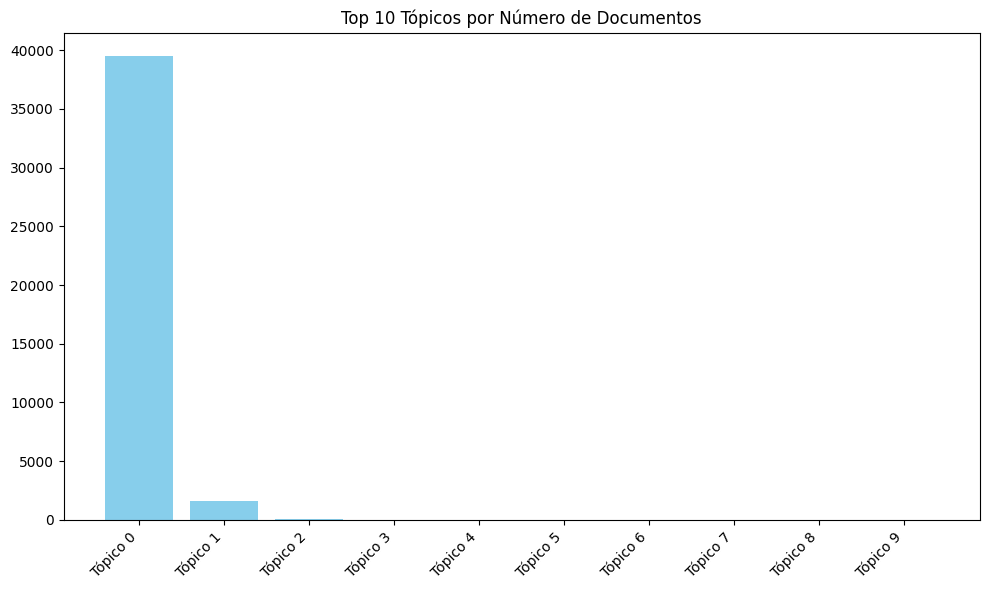

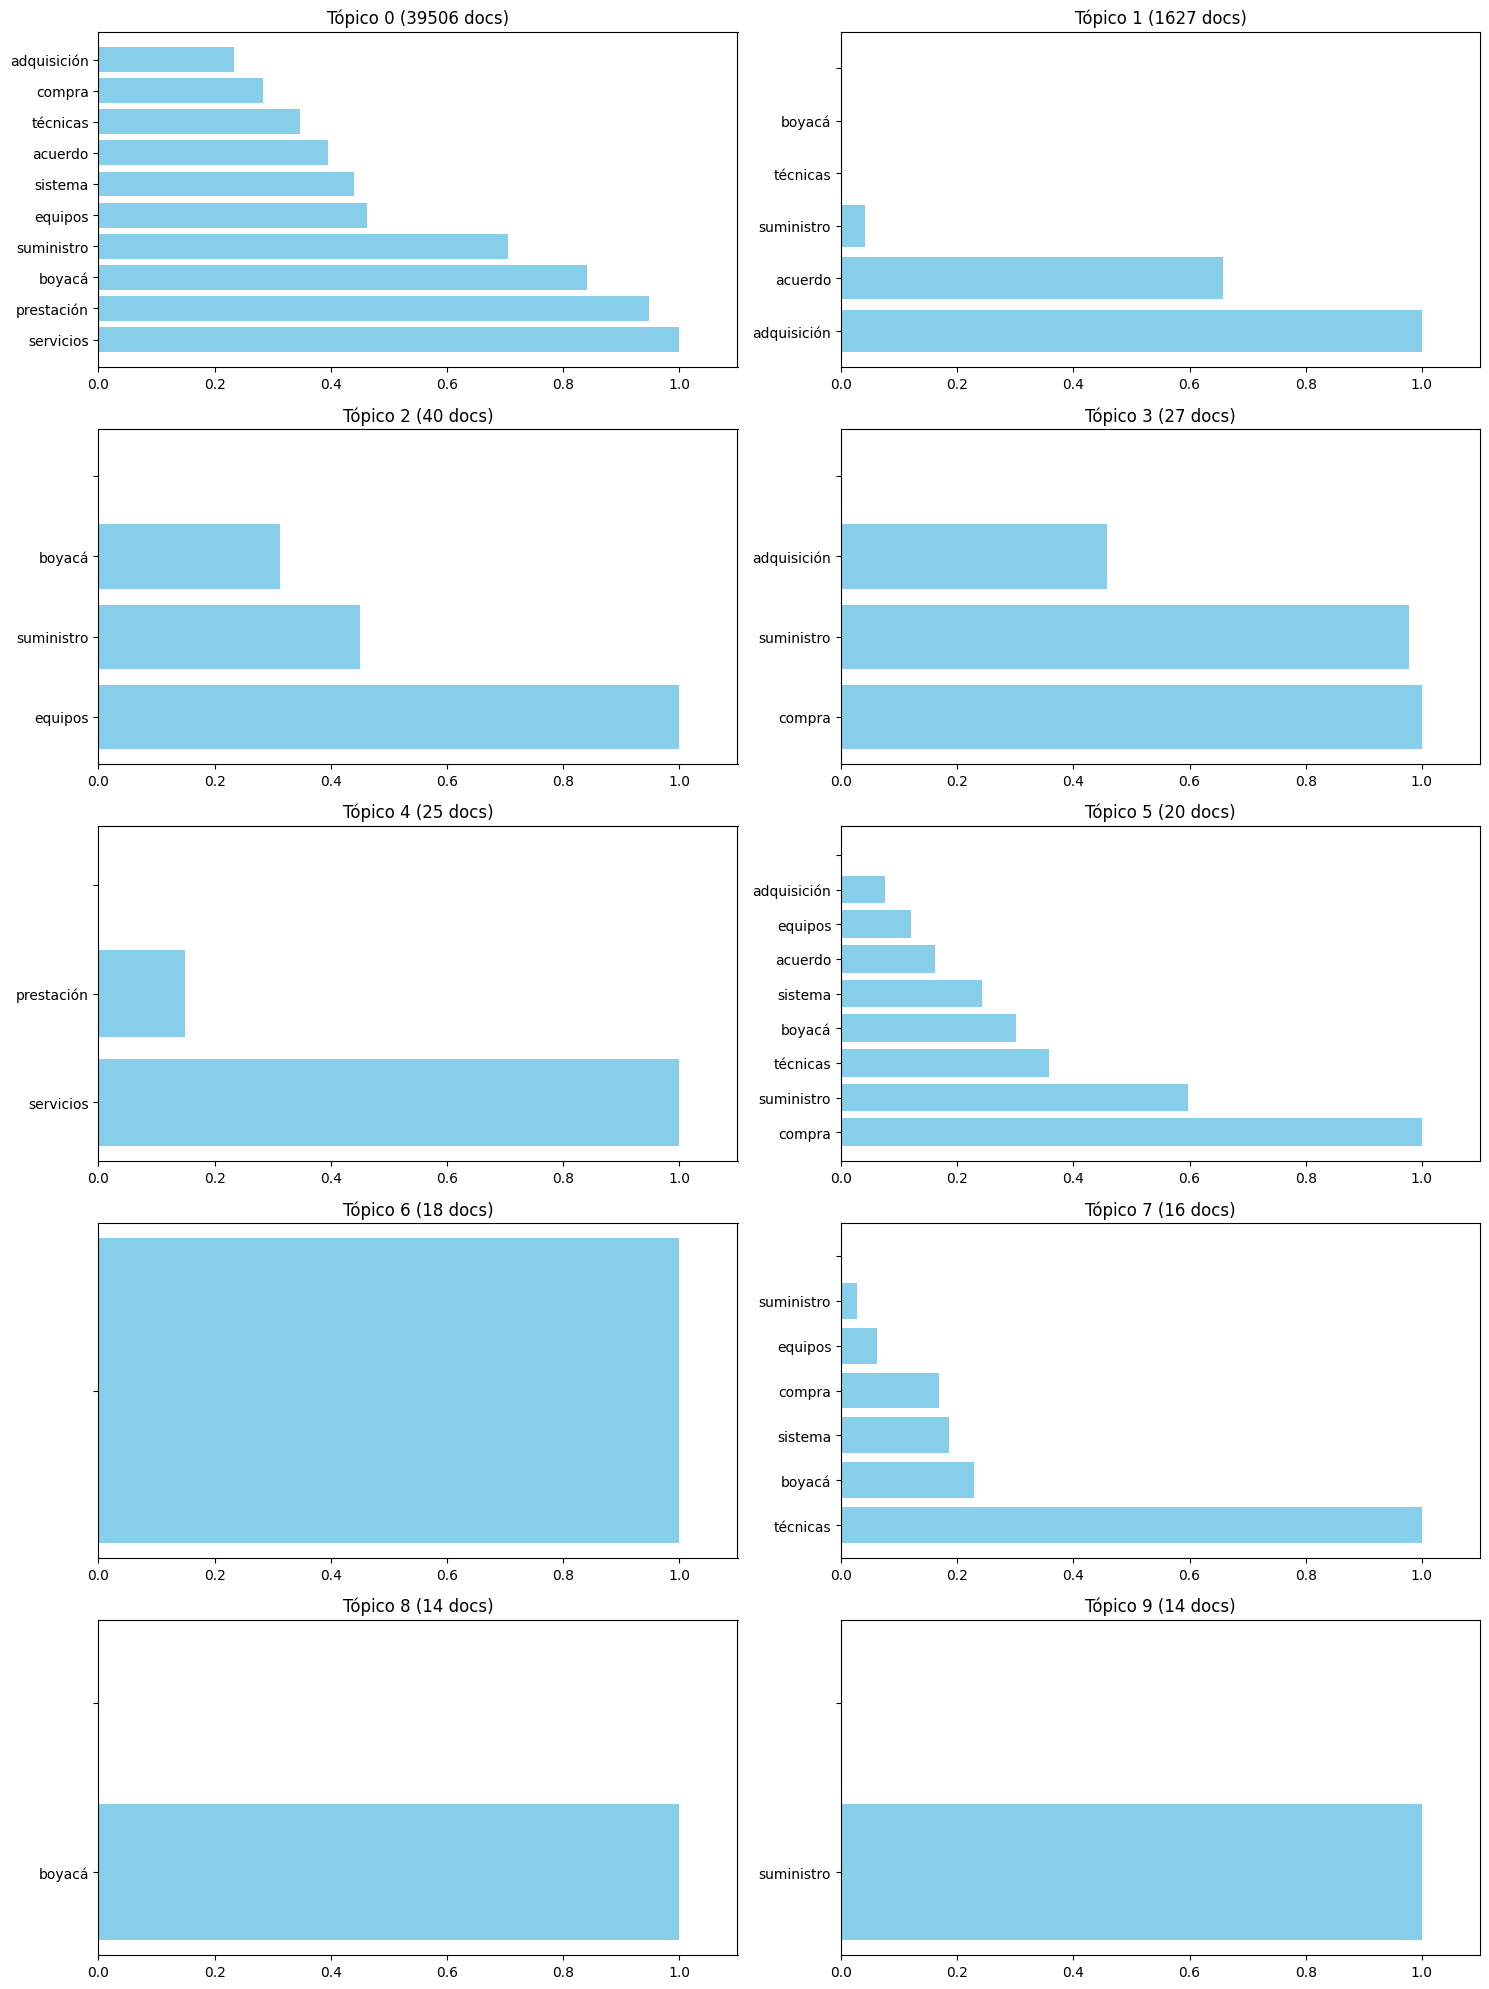

In [14]:
# 8. Crear visualizaciones manuales usando los datos de BERTopic
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Creando visualizaciones manuales basadas en BERTopic...")

# Obtener información de tópicos
topic_info = topic_model.get_topic_info()
print("Información de tópicos disponible:")
print(topic_info.head())

# Visualizar los tópicos principales (excluyendo el -1 que son outliers)
top_topics = topic_info[topic_info.Topic != -1].head(10)

# Crear visualización de barras para los principales tópicos
plt.figure(figsize=(10, 6))
plt.bar(
    [f"Tópico {topic}" for topic in top_topics.Topic],
    top_topics.Count,
    color='skyblue'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Tópicos por Número de Documentos')
plt.tight_layout()
plt.savefig('top_topics_berttopic.png')
plt.show()

# Crear visualización de palabras clave por tópico
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i, topic in enumerate(top_topics.Topic[:10]):
    # Obtener palabras clave y sus pesos
    words = [word for word, _ in topic_model.get_topic(topic)][:10]
    weights = [weight for _, weight in topic_model.get_topic(topic)][:10]

    # Normalizar pesos para mejor visualización
    weights = [w/max(weights) for w in weights]

    # Crear gráfico
    axes[i].barh(words, weights, color='skyblue')
    axes[i].set_title(f'Tópico {topic} ({top_topics.iloc[i].Count} docs)')
    axes[i].set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig('keywords_berttopic.png')
plt.show()

Las palabras clave asociadas a cada tópico permiten identificar su significado principal. En los gráficos de barras horizontales, se observan los términos con mayor peso en cada categoría. Estos términos reflejan los conceptos centrales de los contratos agrupados en cada tópico.

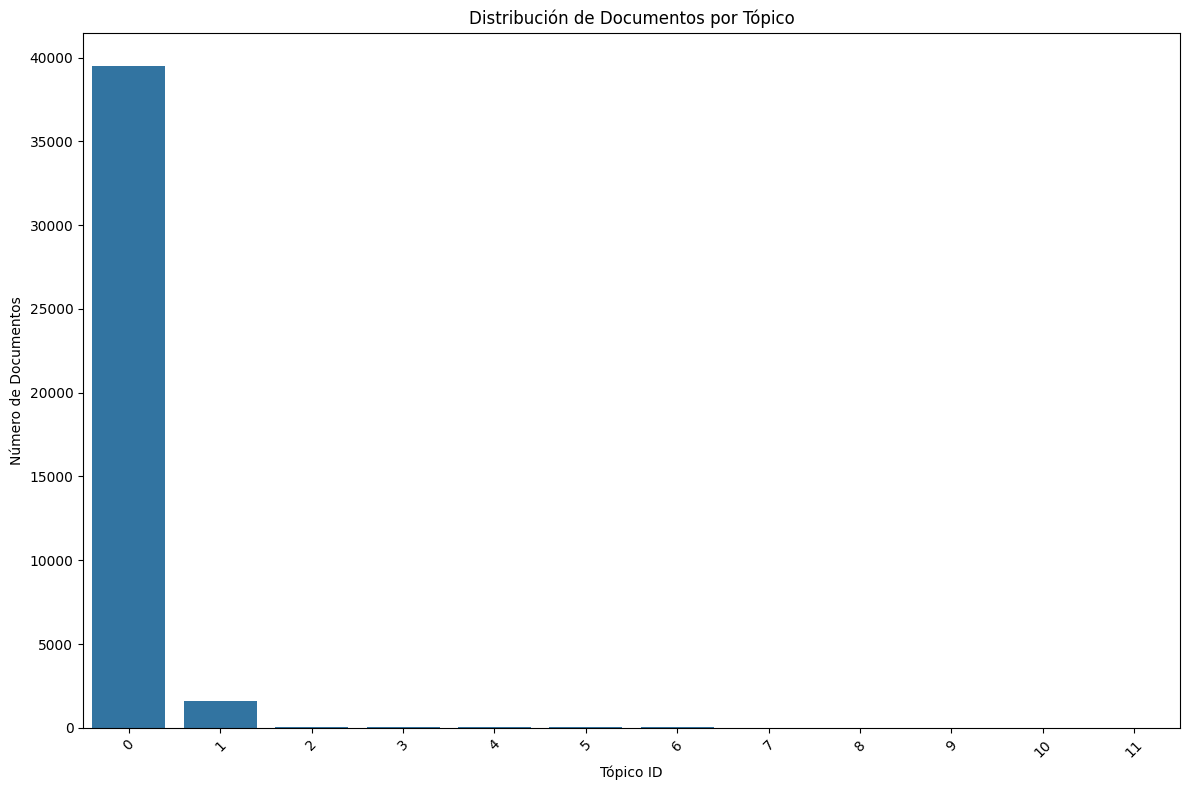

In [15]:
# Distribución de documentos por tópico

# Obtener información de los tópicos
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info.Topic != -1]  # Excluir outliers

# Crear gráfico de barras ordenado
plt.figure(figsize=(12, 8))
sns.barplot(x='Topic', y='Count', data=topic_info.sort_values('Count', ascending=False).head(20))
plt.title('Distribución de Documentos por Tópico')
plt.xlabel('Tópico ID')
plt.ylabel('Número de Documentos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_topicos.png')
plt.show()

Se observa que algunos tópicos agrupan una cantidad significativamente mayor de documentos que otros. Esto sugiere que ciertos temas son más recurrentes en los contratos de Boyacá, mientras que otros pueden estar especializados en subcategorías más pequeñas. La exclusión del tópico -1 (outliers) permite una mejor visualización de los datos relevantes.
Este gráfico también refleja la efectividad de la reducción de clusters. Si la distribución es muy desigual, puede indicar que ciertos tópicos absorbieron demasiados contratos, perdiendo especificidad en la clasificación. Si, por el contrario, los tópicos están bien balanceados, significa que la reducción a 20 categorías mantuvo una segmentación clara y diferenciada.